## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from google.colab import drive
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.utils import shuffle

Accessing Dataset from Drive and Extracting Dataset


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/facial_expression.zip','r') as zip_file:
  zip_file.extractall('/content/extracted_dataset')

Creating A dictionary to save Folder names as Numeric values

In [4]:
labels_name = {0:'sadness', 1:'fear', 2:'neutral', 3:'anger', 4:'happiness', 5:'disgust', 6:'surprise'}


Reading all images from Training Dataset and resizing them

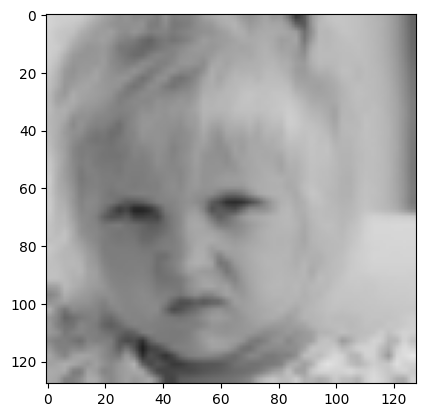

In [5]:
DataPath = '/content/extracted_dataset/Dataset/train'
targetImageSize = (128, 128)

for labels in labels_name:
    img_path = os.path.join(DataPath, labels_name[labels])
    for image in os.listdir(img_path):
        ImagePath = os.path.join(img_path, image)
        image_arr = cv2.imread(ImagePath)

        # Resize the image & convert to RGB
        image_arr = cv2.resize(image_arr, targetImageSize)
        RGB_image = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)

        plt.imshow(RGB_image)
        plt.show()
        break
    break

Function to check if images are blank(black, white) and discarding them from array

In [6]:
def blank_image(image):
    # Calculate mean pixel value
    PixelMean = np.mean(image)

    # Check if the image is not blank (not too bright or too dark)
    return PixelMean <= 20 or PixelMean >= 235

In [9]:
def training_data():
    img_paths, labels = [], []
    for label_num, label_name in labels_name.items():
        path = os.path.join(DataPath, label_name)
        for image_file in os.listdir(path):
            image_path = os.path.join(path, image_file)
            image = cv2.imread(image_path)
            if image is not None and not blank_image(image):
                img_paths.append(image_path)
                labels.append(label_num)

    img_paths = np.array(img_paths)
    labels = np.array(labels)

    return img_paths, labels

img_paths, labels = training_data()

# Function to count the total number of images
def count_total_images(img_paths):
    total_images = len(img_paths)
    return total_images

total_images = count_total_images(img_paths)

print("Total number of images in the dataset:", total_images)

Total number of images in the dataset: 32254


Creating Dataframe

In [10]:
# function to show the full value of 'image_path' in output
pd.set_option('display.max_colwidth', None)

# Function to create DataFrame with image paths and labels
def Dataframe(img_paths, labels):
    df = pd.DataFrame({
        'image_path': img_paths,
        'label': labels.astype(int)
    })
    return df

df = Dataframe(img_paths, labels)
df['label'] = df['label'].astype(str)

print(df.tail(5))

                                                           image_path label
32249  /content/extracted_dataset/Dataset/train/surprise/76548328.png     6
32250   /content/extracted_dataset/Dataset/train/surprise/6352526.png     6
32251  /content/extracted_dataset/Dataset/train/surprise/84204109.png     6
32252  /content/extracted_dataset/Dataset/train/surprise/74688169.png     6
32253  /content/extracted_dataset/Dataset/train/surprise/75493877.png     6


Spliting training data into training and validation data 80% training & 20% Validation

In [11]:
# splitting dataframe
X = df['image_path']
y = df['label']

# Split the data into training and validation sets (80% training, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print("Total Training samples:", len(train_df))
print("Total Validation samples:", len(val_df))

Total Training samples: 25803
Total Validation samples: 6451


Applying Data Generator to Rescaling to Image and data augmentation

In [2]:
# Initialize image data generator with rescaling
training_data_genr = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Initialize image data generator for validation data
validation_data_genr = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create data generators using the flow_from_dataframe method for both training and validation data
train_generator = training_data_genr.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical'
)

validation_generator = validation_data_genr.flow_from_dataframe(
    val_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical'
)


NameError: ignored

Creating a CNN model

In [13]:
# create model structure
emotion_cnn_model = Sequential()

emotion_cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
emotion_cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

emotion_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_cnn_model.add(Dropout(0.25))  ### to avoid overfitting

emotion_cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
emotion_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

emotion_cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
emotion_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_cnn_model.add(Dropout(0.25))

emotion_cnn_model.add(Flatten())
emotion_cnn_model.add(Dense(128, activation='relu'))
emotion_cnn_model.add(Dropout(0.5))
emotion_cnn_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training Our Model on our preprocessed Dataset

In [ ]:
# Train your model using model.fit with data generators
model_history = emotion_cnn_model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator,
    #callbacks=checkpointer
)
# save model structure in jason file
model_json = emotion_cnn_model.to_json()
with open("emotion_cnn_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_cnn_model.save_weights('emotion_cnn_model.h5')

Epoch 1/3
 51/404 [==>...........................] - ETA: 1:39:45 - loss: 1.8472 - accuracy: 0.2307

Ploting Line graph to show Accuracy and Loss

In [1]:
def loss_plot_graph(model_history):
  plt.plot(model_history.history["loss"],'r', label="Training Loss")
  plt.plot(model_history.history["accuracy"],'b', label="Accuracy")
  plt.legend()

loss_plot_graph(model_history)

NameError: ignored

Evaluating Mode

In [32]:
labels_name = {0:'sadness', 1:'fear', 2:'neutral', 3:'anger', 4:'happiness', 5:'disgust', 6:'surprise'}

# load json and create model
json_file = open('/content/emotion_cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_cnn_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_cnn_model.load_weights("/content/emotion_cnn_model.h5")
print("Loaded model from disk")



Loaded model from disk


In [33]:
import os
import cv2

test_path = '/content/extracted_dataset/Dataset/test'
target_size = (128, 128)

for labels in labels_name:
    path = os.path.join(test_path, labels_name[labels])
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        image_arr = cv2.imread(image_path)

        # Resize the image to the target size (128x128)
        image_arr = cv2.resize(image_arr, target_size)

        # Convert BGR to RGB
        image_arr_rgb = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)

        # Save the resized and converted image
        new_image_path = os.path.join(path, f"resized_{image}")
        cv2.imwrite(new_image_path, image_arr_rgb)

print("All images resized and converted to RGB.")


All images resized and converted to RGB.


In [35]:
# Initialize image data generator with rescaling
test_data_genr = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
test_generator = test_data_genr.flow_from_directory(
        '/content/extracted_dataset/Dataset/test',
        target_size=(128, 128),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# do prediction on test data
predictions = emotion_cnn_model.predict_generator(test_generator)

# see predictions
for result in predictions:
  max_index = int(np.argmax(result))
  print(labels_name[max_index])

Found 7178 images belonging to 7 classes.


<ipython-input-35-6099e769f065>:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(test_generator)


InvalidArgumentError: ignored

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(conf_matrix)
display_CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_name)
display_CM.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))